In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torchvision import utils

# Load the datasets

In [2]:
# Load MNIST dataset
train_data = torchvision.datasets.MNIST(root="./",train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root="./",train=False,transform=transforms.ToTensor(),download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 49899436.20it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1689314.76it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 11414509.32it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4042981.49it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
# Hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 200
no_of_eigen_val = 30 # number of principal components (for PCA)


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=len(test_data),shuffle=False)


In [5]:
# Creating a DataLoader for a subset of test_data
test_sample_loader = torch.utils.data.DataLoader(dataset=test_data.data[9705:9715],shuffle=False,batch_size=10)

In [6]:
train_dataset = train_data.data.reshape(train_data.data.shape[0],train_data.data.shape[1]*train_data.data.shape[2])
test_dataset = test_data.data.reshape(test_data.data.shape[0],test_data.data.shape[1]*test_data.data.shape[2])
test_dataset_sampled = test_dataset[np.arange(9705, 9715),:] # slicing & creating a new subset from test_dataset

# Comparing PCA and autoencoders

In [7]:
# i/p data is a 2D tensor of shape (num_datapts, 784)
def PCA(input_data, top_k_ev):
  # mean calculation and centering
  input_mean = torch.mean(input_data, 0)
  centered_data_matrix = input_data - input_mean

  # Covariance Matrix
  cov_matrix = torch.matmul(centered_data_matrix.T, centered_data_matrix) # dot pdt

  # Eigenvalues and Eigenvectors
  eigen_values, eigen_vectors = torch.linalg.eigh(cov_matrix) #  eigenvalues: vector of length 784, eigen_vectors: matrix of shape (784, 784)
  sorted_eigen_vals, sorted_indices = torch.sort(eigen_values, descending=True) # sorting the eigenvalues & corresponding Eigenvectors

  # Select the top k eigenvectors and eigenvalues
  top_k_eigen_values, top_k_indices = sorted_eigen_vals[:top_k_ev], sorted_indices[:top_k_ev]
  top_k_eigen_vectors = eigen_vectors[:,top_k_indices]

  assert top_k_eigen_vectors.shape == (784, top_k_ev) # checks the shape
  assert centered_data_matrix.shape == input_data.shape
  assert input_mean.shape == torch.Size([784])

  return top_k_eigen_vectors

In [8]:
pc = PCA(train_dataset.float(), no_of_eigen_val) # (784, top_k)

In [9]:
# reconstruct the original dataset (in its original high-dimensional space) using a reduced no:of principal components obtained from PCA.
def reconstruct_data(principal_components, dataset): # principal_components: matrix of shape (784, top_k_ev)

  # Create the projection matrix
  projection_matrix = torch.matmul(principal_components, principal_components.T) # matrix of shape (784, 784)

  # project the dataset using the projection matrix
  projected_data = torch.matmul(dataset, projection_matrix)
  # each data point in dataset is projected back into the original 784-dimensional space using the top k principal components

  assert projected_data.shape == (dataset.shape[0],principal_components.shape[0])
  return projected_data

In [10]:
reconstructed_test_data_sampled = reconstruct_data(pc, test_dataset_sampled.float())

In [11]:
# Autoencoder neural network
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential( # encoder part
        nn.Linear(784,512), # i/p has 784 dimensions - 28x28
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder = nn.Sequential(  # decoder part
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())

  # forward pass
  def forward(self,x): # shape of x (batch_size, 784))
    x = self.encoder(x)
    encoded_output = x
    x = self.decoder(x)
    return x, encoded_output

In [12]:
model1 = AutoEncoder()
criterion1 = nn.MSELoss() # loss function
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate) # adam optimizer is used

# Training loop
training_loss=[]
for epoch in range(epochs):
  for images, labels in train_loader:
    images = images.reshape(images.shape[0], -1) # 2D to 1D vector
    outputs, _ = model1(images) # reconstructed images
    loss = criterion1(outputs, images) # reconstruction error
    training_loss.append(loss.item())

    optimizer1.zero_grad() # clears the gradients from the previous batch
    loss.backward() # backpropagation
    optimizer1.step() # update the model parameter

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))
  #print("Epoch [{}/{}]: completed".format(epoch + 1, epochs))

Epoch [1/10]: completed, Loss: 0.0323
Epoch [2/10]: completed, Loss: 0.0241
Epoch [3/10]: completed, Loss: 0.0208
Epoch [4/10]: completed, Loss: 0.0173
Epoch [5/10]: completed, Loss: 0.0173
Epoch [6/10]: completed, Loss: 0.0169
Epoch [7/10]: completed, Loss: 0.0161
Epoch [8/10]: completed, Loss: 0.0144
Epoch [9/10]: completed, Loss: 0.0140
Epoch [10/10]: completed, Loss: 0.0135


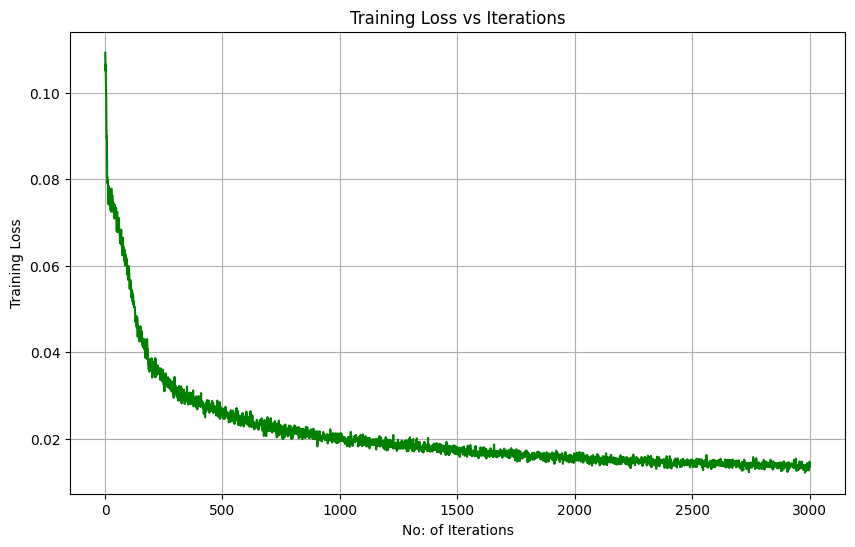

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(training_loss)+1),training_loss, color='green')
plt.title("Training Loss vs Iterations")
plt.xlabel("No: of Iterations")
plt.ylabel("Training Loss")
plt.grid()

Reconstruction Error in AE: 5.691166534542718
Reconstruction Error in PCA: 4.906910216143052


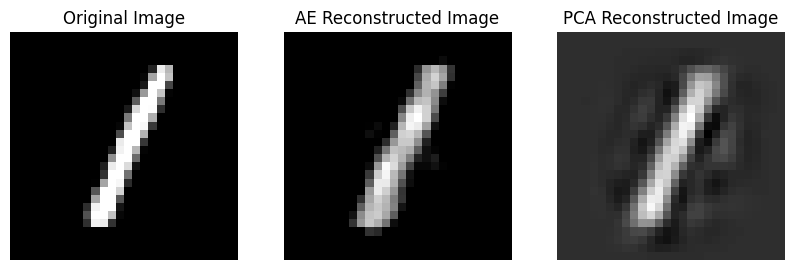

Reconstruction Error in AE: 22.501498098583298
Reconstruction Error in PCA: 16.862376030476067


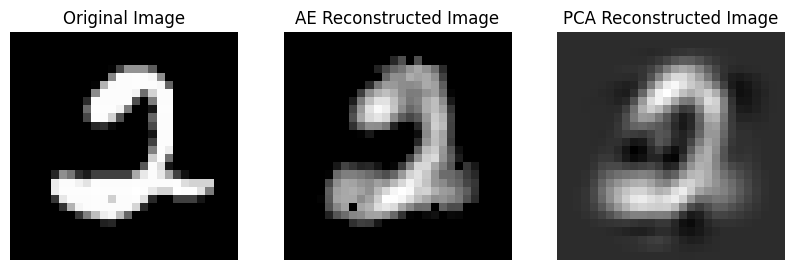

Reconstruction Error in AE: 16.95740524825588
Reconstruction Error in PCA: 16.0457551172948


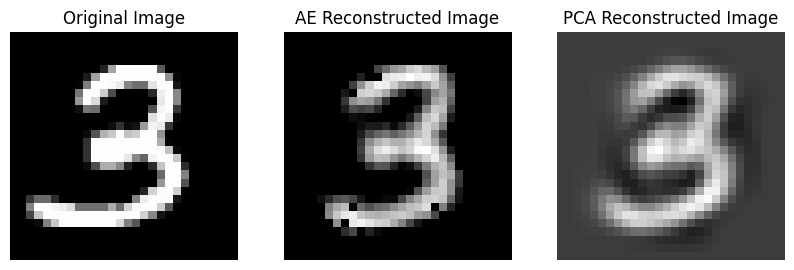

Reconstruction Error in AE: 8.214758552356034
Reconstruction Error in PCA: 10.714796514097081


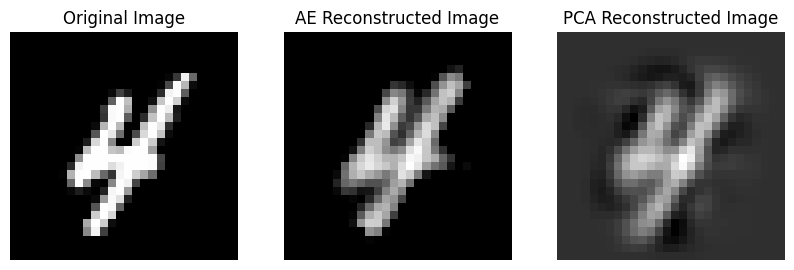

Reconstruction Error in AE: 13.424592590766943
Reconstruction Error in PCA: 14.848193155147694


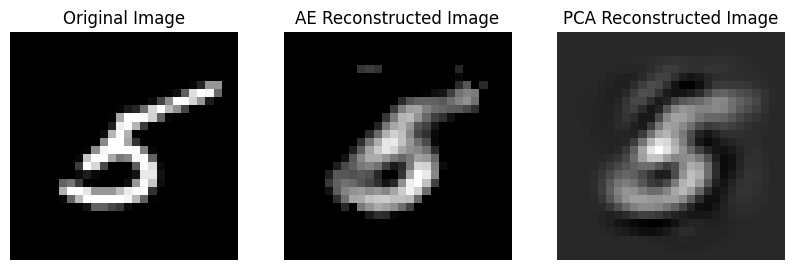

In [14]:
# Model evaluation
model1.eval() # evaluation mode
with torch.no_grad(): # disables gradient calculation

  # reshaping and passing test images through the AE
  for images in test_sample_loader:
    images = images.reshape(10, 28*28) # reshape from 2D to 1D
    outputs, _ = model1(images.float()) # reconstructed images

# visualization and plotting
plt.rcParams["figure.figsize"] = (10,6) # rcParams:set global parameters for plot
for i in range (5): # iterates over 10 images
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)

  ax1.imshow(images[i].detach().numpy().reshape(28,28), cmap ='gray') # original image
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs[i].detach().numpy().reshape(28,28), cmap ='gray') # reconctructed image
  ax2.set_title('AE Reconstructed Image')
  ax2.axis("off")

  ax3.imshow(reconstructed_test_data_sampled[i].reshape(28,28), cmap ='gray') # PCA reconstructed image
  ax3.set_title('PCA Reconstructed Image')
  ax3.axis("off")
  print("Reconstruction Error in AE:",np.dot(((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)),
                                            ((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)).T))

  print("Reconstruction Error in PCA:",np.dot(((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)),
                                              ((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)).T))
  plt.show()

# Standard Autoencoder

In [15]:
# Under-complete AutoEncoder - one hidden layer
class Standard_AE(nn.Module):
  def __init__(self,hid):
    super(Standard_AE, self).__init__()
    self.hid = hid  # stores the no: of neurons in the hidden layer (hid)
    self.encoder = nn.Sequential(
        nn.Linear(784, self.hid),
        nn.ReLU()
        )
    self.decoder = nn.Sequential(
        nn.Linear(self.hid, 784),
        nn.ReLU()
        )

  def forward(self, x):
    x = self.encoder(x)
    encoded_output = x
    x = self.decoder(x)
    return x, encoded_output

In [16]:
# Hiddensize 64
model_hid_64 = Standard_AE(64)
criterion_hid64 = nn.MSELoss()
optimizer_hid64 = torch.optim.Adam(model_hid_64.parameters(), lr=learning_rate)

training_loss_hid64 = []

# Training loop for the specified number of epochs
for epoch in range(epochs):
  for images, labels in train_loader:
    images = images.reshape(images.shape[0], -1)
    outputs, _ = model_hid_64(images) # reconstructed images
    loss = criterion_hid64(outputs, images)
    training_loss_hid64.append(loss.item())

    optimizer_hid64.zero_grad()
    loss.backward()
    optimizer_hid64.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0173
Epoch [2/10]: completed, Loss: 0.0137
Epoch [3/10]: completed, Loss: 0.0131
Epoch [4/10]: completed, Loss: 0.0121
Epoch [5/10]: completed, Loss: 0.0118
Epoch [6/10]: completed, Loss: 0.0122
Epoch [7/10]: completed, Loss: 0.0116
Epoch [8/10]: completed, Loss: 0.0118
Epoch [9/10]: completed, Loss: 0.0118
Epoch [10/10]: completed, Loss: 0.0120


In [17]:
# Hiddensize 128
model_hid_128 = Standard_AE(128)
criterion_hid128=nn.MSELoss()
optimizer_hid128 = torch.optim.Adam(model_hid_128.parameters(), lr=learning_rate)

training_loss_hid128 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0], -1)
    outputs, _ = model_hid_128(images)
    loss = criterion_hid128(outputs,images)
    training_loss_hid128.append(loss.item())

    optimizer_hid128.zero_grad()
    loss.backward()
    optimizer_hid128.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0137
Epoch [2/10]: completed, Loss: 0.0109
Epoch [3/10]: completed, Loss: 0.0099
Epoch [4/10]: completed, Loss: 0.0089
Epoch [5/10]: completed, Loss: 0.0087
Epoch [6/10]: completed, Loss: 0.0082
Epoch [7/10]: completed, Loss: 0.0083
Epoch [8/10]: completed, Loss: 0.0094
Epoch [9/10]: completed, Loss: 0.0092
Epoch [10/10]: completed, Loss: 0.0086


In [18]:
# Hiddensize 256
model_hid_256 = Standard_AE(256)
criterion_hid256=nn.MSELoss()
optimizer_hid256 = torch.optim.Adam(model_hid_256.parameters(),lr=learning_rate)

training_loss_hid256=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs, _ = model_hid_256(images)
    loss = criterion_hid256(outputs,images)
    training_loss_hid256.append(loss.item())

    optimizer_hid256.zero_grad()
    loss.backward()
    optimizer_hid256.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0096
Epoch [2/10]: completed, Loss: 0.0083
Epoch [3/10]: completed, Loss: 0.0071
Epoch [4/10]: completed, Loss: 0.0072
Epoch [5/10]: completed, Loss: 0.0066
Epoch [6/10]: completed, Loss: 0.0061
Epoch [7/10]: completed, Loss: 0.0059
Epoch [8/10]: completed, Loss: 0.0063
Epoch [9/10]: completed, Loss: 0.0061
Epoch [10/10]: completed, Loss: 0.0063


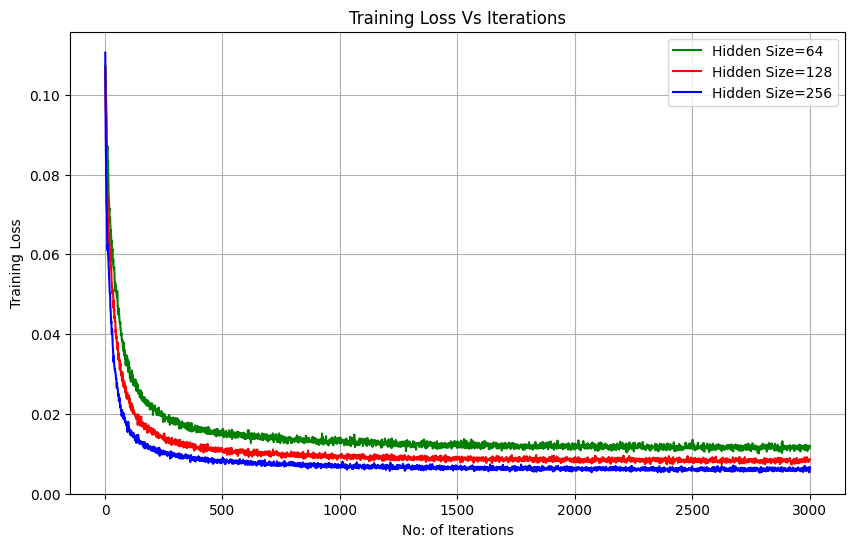

In [19]:
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid64,label="Hidden Size=64", color='green')
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid128,label="Hidden Size=128", color='red')
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid256,label="Hidden Size=256", color='blue')
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("No: of Iterations")
plt.ylabel("Training Loss")
plt.show()

In [20]:
model_hid_64.eval()
with torch.no_grad():  # disable gradient calculation
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10, 28*28)
    outputs_hid64, _ = model_hid_64(images.float()) # Forward pass through the model to get reconstructed outputs


In [21]:
model_hid_128.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid128, _ = model_hid_128(images.float())

In [22]:
model_hid_256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid256, activations_hid256 = model_hid_256(images.float())

Reconstruction Error in hidden layer 64: 11.977818158376152
Reconstruction Error in hidden layer 128: 8.45122520312671
Reconstruction Error in hidden layer 256: 4.126620662363191


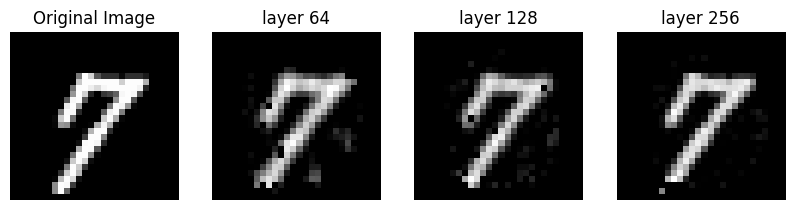

In [23]:
# Reconstruction from testset image
plt.rcParams["figure.figsize"] = (10,6)
i = 6
if i==6:
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_hid64[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('layer 64')
  ax2.axis("off")

  ax3.imshow(outputs_hid128[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('layer 128')
  ax3.axis("off")

  ax4.imshow(outputs_hid256[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('layer 256')
  ax4.axis("off")

  print("Reconstruction Error in hidden layer 64:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)),
                                                    ((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)).T))

  print("Reconstruction Error in hidden layer 128:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)),
                                                    ((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)).T))

  print("Reconstruction Error in hidden layer 256:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)),
                                                    ((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)).T))


In [24]:
# Reconstruction from non-digit images - Fashion MNIST o/p
test_data_fashion = torchvision.datasets.FashionMNIST(root="./",train=False,transform=transforms.ToTensor(),download=True)
fashion_image_sample = test_data_fashion.data[9]


100%|██████████| 26421880/26421880 [00:07<00:00, 3322378.70it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303418.09it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5524544.04it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6593061.68it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [25]:
model_hid_64.eval()
with torch.no_grad():
    images = fashion_image_sample.reshape(1,28*28)
    outputs_hid64,_ = model_hid_64(images.float())

In [26]:
model_hid_128.eval()
with torch.no_grad():
  images = fashion_image_sample.reshape(1,28*28)
  outputs_hid128,_ = model_hid_128(images.float())

In [27]:
model_hid_256.eval()
with torch.no_grad():
  images = fashion_image_sample.reshape(1,28*28)
  outputs_hid256,_ = model_hid_256(images.float())

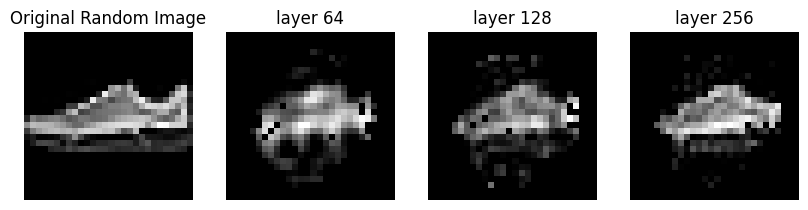

In [28]:
plt.rcParams["figure.figsize"] = (10,6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.imshow(fashion_image_sample.detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")

ax2.imshow(outputs_hid64.detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('layer 64')
ax2.axis("off")

ax3.imshow(outputs_hid128.detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('layer 128')
ax3.axis("off")

ax4.imshow(outputs_hid256.detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('layer 256')
ax4.axis("off")
plt.show()


In [29]:
# random noise images
torch.manual_seed(0)
random_image = torch.randint(low=0, high=255,size=(1,28,28))

In [30]:
model_hid_64.eval()
with torch.no_grad():
    images = random_image.reshape(1,28*28)
    outputs_hid64,_ = model_hid_64(images.float())

In [31]:
model_hid_128.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid128,_ = model_hid_128(images.float())

In [32]:
model_hid_256.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid256,_ = model_hid_256(images.float())

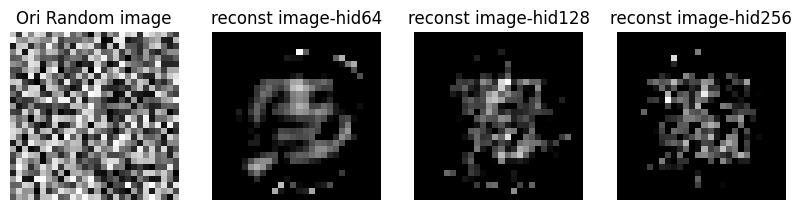

In [33]:
plt.rcParams["figure.figsize"] = (10,6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.imshow(random_image.numpy().reshape(28,28),cmap='gray')
ax1.set_title('Ori Random image')
ax1.axis("off")

ax2.imshow(outputs_hid64.detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('reconst image-hid64')
ax2.axis("off")

ax3.imshow(outputs_hid128.detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('reconst image-hid128')
ax3.axis("off")

ax4.imshow(outputs_hid256.detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('reconst image-hid256')
ax4.axis("off")
plt.show()


# Sparse Autoencoders

In [34]:
# over-complete autoencoder (AE) with sparsity regularization using L1 penalty on the hidden layer activations
class Sparse_AE(nn.Module):
  def __init__(self):
    super(Sparse_AE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 1024), # Over-complete layer
        nn.ReLU())
    self.decoder = nn.Sequential(
        nn.Linear(1024, 784), # Reconstruction back to input dimension
        nn.ReLU())

  def forward(self,x):
    x = self.encoder(x) # encoded output
    encoded_output = x
    l1_norm = torch.norm(x, p=1) # calculate L1 norm of the activations
    x = self.decoder(x) # Get reconstructed output
    return x, l1_norm, encoded_output

In [35]:
sparsity_param  = 0.5*1e-6 # Sparsity regularization weight
model_sparse1 = Sparse_AE()
criterion_sparse1 = nn.MSELoss()
optimizer_sparse1 = torch.optim.Adam(model_sparse1.parameters(),lr=learning_rate)

training_loss_sparse1 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    outputs, l1_norm, _ = model_sparse1(images)
    loss = criterion_sparse1(outputs,images) + sparsity_param * l1_norm
    training_loss_sparse1.append(loss.item())

    optimizer_sparse1.zero_grad()
    loss.backward()
    optimizer_sparse1.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0129
Epoch [2/10]: completed, Loss: 0.0102
Epoch [3/10]: completed, Loss: 0.0091
Epoch [4/10]: completed, Loss: 0.0086
Epoch [5/10]: completed, Loss: 0.0076
Epoch [6/10]: completed, Loss: 0.0079
Epoch [7/10]: completed, Loss: 0.0071
Epoch [8/10]: completed, Loss: 0.0075
Epoch [9/10]: completed, Loss: 0.0065
Epoch [10/10]: completed, Loss: 0.0070


In [36]:
sparsity_param  = 3*1e-6
model_sparse2 = Sparse_AE()
criterion_sparse2 = nn.MSELoss()
optimizer_sparse2 = torch.optim.Adam(model_sparse2.parameters(),lr=learning_rate)

training_loss_sparse2=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    outputs, l1_norm, _ = model_sparse2(images)
    loss = criterion_sparse2(outputs,images) + sparsity_param * l1_norm
    training_loss_sparse2.append(loss.item())

    optimizer_sparse2.zero_grad()
    loss.backward()
    optimizer_sparse2.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0249
Epoch [2/10]: completed, Loss: 0.0207
Epoch [3/10]: completed, Loss: 0.0178
Epoch [4/10]: completed, Loss: 0.0167
Epoch [5/10]: completed, Loss: 0.0164
Epoch [6/10]: completed, Loss: 0.0156
Epoch [7/10]: completed, Loss: 0.0143
Epoch [8/10]: completed, Loss: 0.0140
Epoch [9/10]: completed, Loss: 0.0135
Epoch [10/10]: completed, Loss: 0.0131


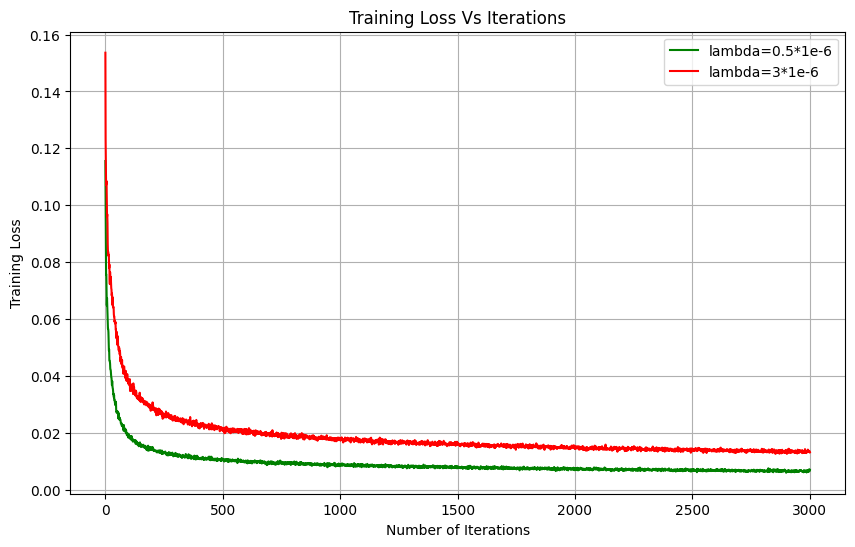

In [37]:
plt.plot(range(1,len(training_loss_sparse2)+1),training_loss_sparse1,label="lambda=0.5*1e-6", color='green')
plt.plot(range(1,len(training_loss_sparse2)+1),training_loss_sparse2,label="lambda=3*1e-6", color='red')
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()


In [38]:
model_sparse1.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_sparse1, _ ,activation_sparse1 = model_sparse1(images.float())


In [39]:
model_sparse2.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_sparse2, _ , activation_sparse2 = model_sparse2(images.float())

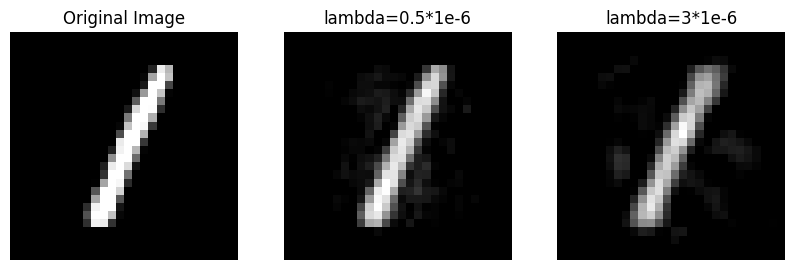

Reconstruction Error in SparseAE lambda = 0.5*1e-6 : 2.208584472857042
Reconstruction Error in SparseAE lambda = 3*1e-6: 3.6315592919954067


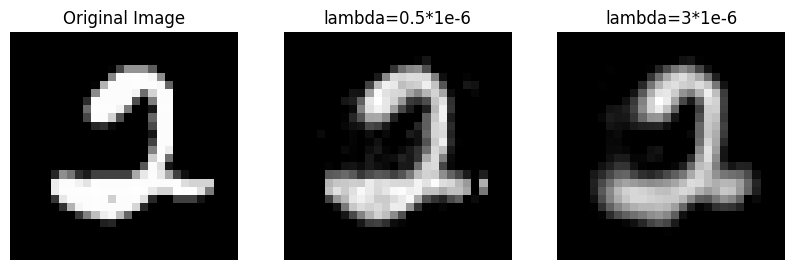

Reconstruction Error in SparseAE lambda = 0.5*1e-6 : 7.516961848370433
Reconstruction Error in SparseAE lambda = 3*1e-6: 10.700766658500626


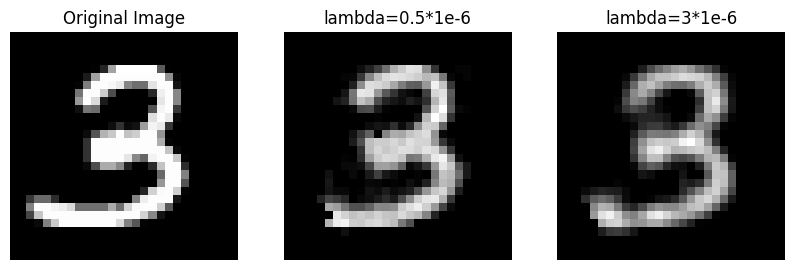

Reconstruction Error in SparseAE lambda = 0.5*1e-6 : 11.913395591403894
Reconstruction Error in SparseAE lambda = 3*1e-6: 11.123511602439438


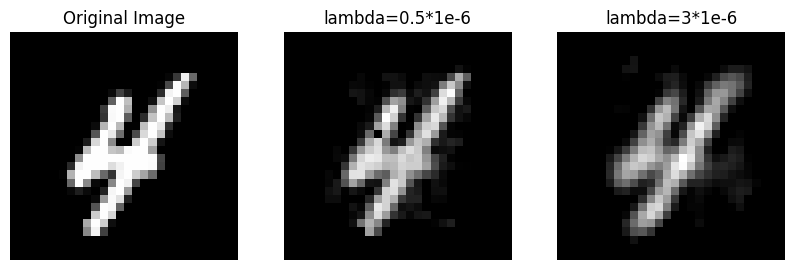

Reconstruction Error in SparseAE lambda = 0.5*1e-6 : 5.362101635436673
Reconstruction Error in SparseAE lambda = 3*1e-6: 7.693300529837552


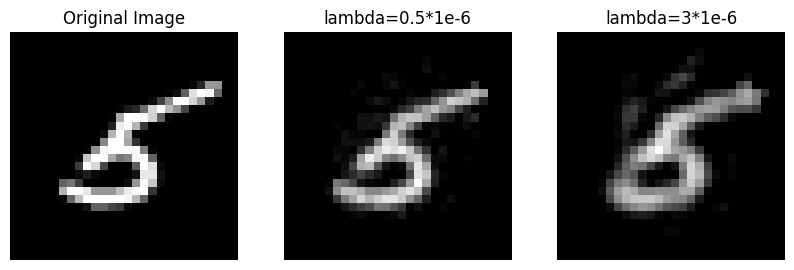

Reconstruction Error in SparseAE lambda = 0.5*1e-6 : 4.129679657692563
Reconstruction Error in SparseAE lambda = 3*1e-6: 9.108881331487623


In [40]:
plt.rcParams["figure.figsize"] = (10,6)

for i in range(5):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_sparse1[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('lambda=0.5*1e-6')
  ax2.axis("off")

  ax3.imshow(outputs_sparse2[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('lambda=3*1e-6')
  ax3.axis("off")


  plt.show()

  print("Reconstruction Error in SparseAE lambda = 0.5*1e-6 :",np.dot(((images[i].detach().numpy()/255)-(outputs_sparse1[i].detach().numpy()/255)),
                                                                  ((images[i].detach().numpy()/255)-(outputs_sparse1[i].detach().numpy()/255)).T))

  print("Reconstruction Error in SparseAE lambda = 3*1e-6:",np.dot(((images[i].detach().numpy()/255)-(outputs_sparse2[i].detach().numpy()/255)),
                                                                    ((images[i].detach().numpy()/255)-(outputs_sparse2[i].detach().numpy()/255)).T))


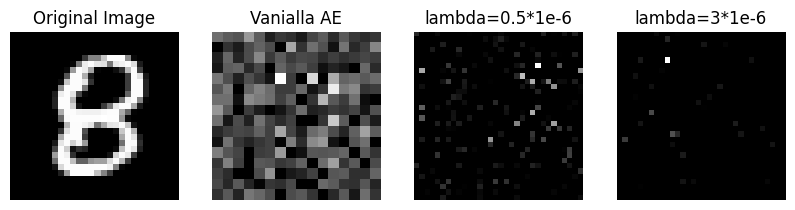

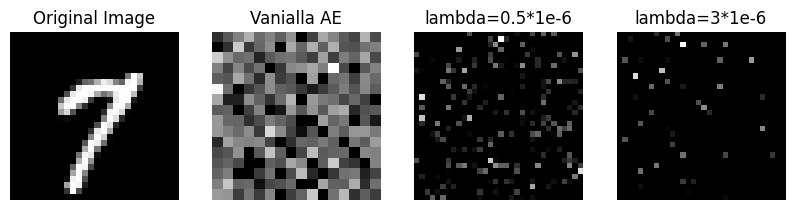

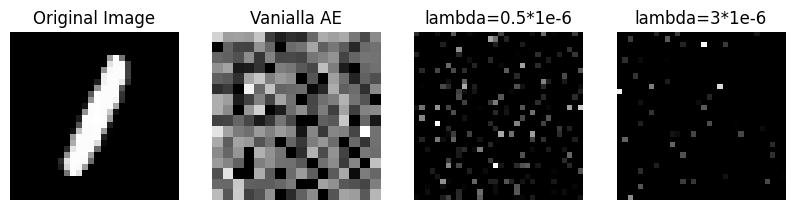

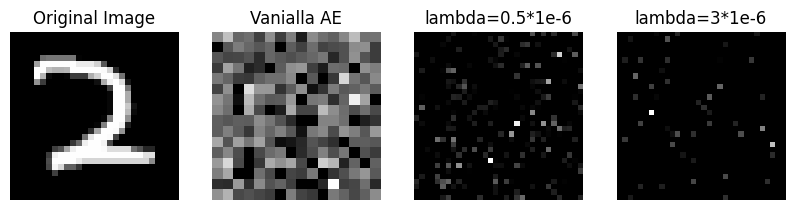

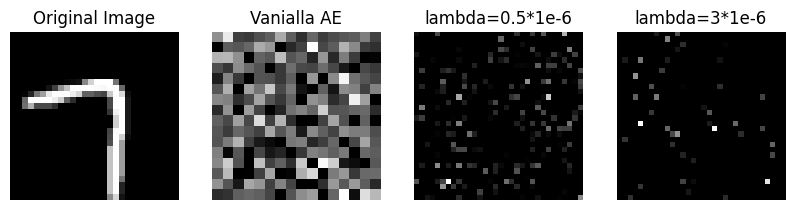

In [48]:
# visualize the learned filters of the Sparse AE as images
plt.rcParams["figure.figsize"] = (10,6)
for i in range(5):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(np.array(activations_hid256.detach().numpy())[i].reshape(int(np.sqrt(256)),int(np.sqrt(256))),cmap='gray')
  ax2.set_title('Vanialla AE')
  ax2.axis("off")

  ax3.imshow(np.array(activation_sparse1.detach().numpy())[i].reshape(int(np.sqrt(1024)),int(np.sqrt(1024))),cmap='gray')
  ax3.set_title('lambda=0.5*1e-6')
  ax3.axis("off")

  ax4.imshow(np.array(activation_sparse2.detach().numpy())[i].reshape(int(np.sqrt(1024)),int(np.sqrt(1024))),cmap='gray')
  ax4.set_title('lambda=3*1e-6')
  ax4.axis("off")

plt.show()

# Denoising Autoencoders

In [42]:
class Denoising_AE(nn.Module):
  def __init__(self):
    super(Denoising_AE, self).__init__()
    self.encoder = nn.Sequential( # encoder
        nn.Linear(784, 256),
        nn.ReLU())
    self.decoder = nn.Sequential( # decoder
        nn.Linear(256, 784),
        nn.ReLU())

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [43]:
def add_noise(img, noise_val):
  noise = torch.randn(img.size()) * noise_val
  noisy_img = img + noise
  return noisy_img

In [44]:
# Hyperparameters
learning_rate = 0.0001
epochs = 10
batch_size = 200

In [45]:
model_denoise1 = Denoising_AE()
criterion_denoise1 = nn.MSELoss()
optimizer_denoise1 = torch.optim.Adam(model_denoise1.parameters(),lr=learning_rate)

training_loss_denoise1 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    noisy_images = add_noise(images, 0.3)
    outputs = model_denoise1(noisy_images)
    loss = criterion_denoise1(outputs, images)
    training_loss_denoise1.append(loss.item())

    optimizer_denoise1.zero_grad()
    loss.backward()
    optimizer_denoise1.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0285
Epoch [2/10]: completed, Loss: 0.0183
Epoch [3/10]: completed, Loss: 0.0149
Epoch [4/10]: completed, Loss: 0.0139
Epoch [5/10]: completed, Loss: 0.0127
Epoch [6/10]: completed, Loss: 0.0113
Epoch [7/10]: completed, Loss: 0.0110
Epoch [8/10]: completed, Loss: 0.0114
Epoch [9/10]: completed, Loss: 0.0116
Epoch [10/10]: completed, Loss: 0.0109


In [46]:
model_denoise2 = Denoising_AE()
criterion_denoise2 = nn.MSELoss()
optimizer_denoise2 = torch.optim.Adam(model_denoise2.parameters(),lr=learning_rate)

training_loss_denoise2 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    noisy_images = add_noise(images,0.5)
    outputs = model_denoise2(noisy_images)
    loss = criterion_denoise2(outputs, images)
    training_loss_denoise2.append(loss.item())

    optimizer_denoise2.zero_grad()
    loss.backward()
    optimizer_denoise2.step()
  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0354
Epoch [2/10]: completed, Loss: 0.0252
Epoch [3/10]: completed, Loss: 0.0215
Epoch [4/10]: completed, Loss: 0.0198
Epoch [5/10]: completed, Loss: 0.0196
Epoch [6/10]: completed, Loss: 0.0182
Epoch [7/10]: completed, Loss: 0.0177
Epoch [8/10]: completed, Loss: 0.0175
Epoch [9/10]: completed, Loss: 0.0175
Epoch [10/10]: completed, Loss: 0.0177


In [47]:
model_denoise3 = Denoising_AE()
criterion_denoise3 = nn.MSELoss()
optimizer_denoise3 = torch.optim.Adam(model_denoise3.parameters(),lr=learning_rate)

training_loss_denoise3 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    noisy_images = add_noise(images, 0.8)
    outputs = model_denoise3(noisy_images)
    loss = criterion_denoise3(outputs, images)
    training_loss_denoise3.append(loss.item())

    optimizer_denoise3.zero_grad()
    loss.backward()
    optimizer_denoise3.step()
  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0464
Epoch [2/10]: completed, Loss: 0.0347
Epoch [3/10]: completed, Loss: 0.0318
Epoch [4/10]: completed, Loss: 0.0304
Epoch [5/10]: completed, Loss: 0.0280
Epoch [6/10]: completed, Loss: 0.0281
Epoch [7/10]: completed, Loss: 0.0261
Epoch [8/10]: completed, Loss: 0.0260
Epoch [9/10]: completed, Loss: 0.0255
Epoch [10/10]: completed, Loss: 0.0258


In [49]:
model_denoise4 = Denoising_AE()
criterion_denoise4 = nn.MSELoss()
optimizer_denoise4 = torch.optim.Adam(model_denoise4.parameters(),lr=learning_rate)

training_loss_denoise4 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    images = images.reshape(images.shape[0],-1)
    noisy_images = add_noise(images, 0.9)
    outputs = model_denoise4(noisy_images)
    loss = criterion_denoise4(outputs, images)
    training_loss_denoise4.append(loss.item())

    optimizer_denoise4.zero_grad()
    loss.backward()
    optimizer_denoise4.step()
  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0490
Epoch [2/10]: completed, Loss: 0.0395
Epoch [3/10]: completed, Loss: 0.0349
Epoch [4/10]: completed, Loss: 0.0327
Epoch [5/10]: completed, Loss: 0.0308
Epoch [6/10]: completed, Loss: 0.0300
Epoch [7/10]: completed, Loss: 0.0288
Epoch [8/10]: completed, Loss: 0.0288
Epoch [9/10]: completed, Loss: 0.0281
Epoch [10/10]: completed, Loss: 0.0277


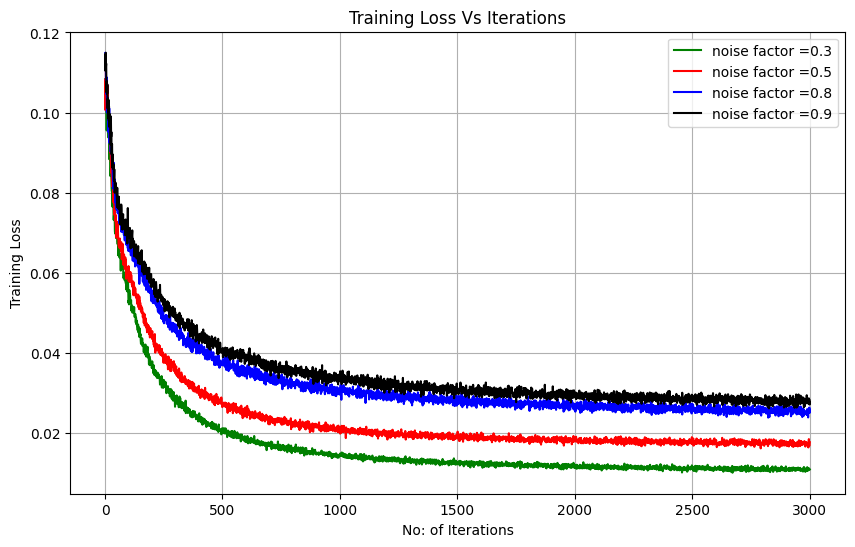

In [50]:
plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(range(1,len(training_loss_denoise1)+1),training_loss_denoise1,label="noise factor =0.3", color='green')
plt.plot(range(1,len(training_loss_denoise1)+1),training_loss_denoise2,label="noise factor =0.5", color='red')
plt.plot(range(1,len(training_loss_denoise1)+1),training_loss_denoise3,label="noise factor =0.8", color='blue')
plt.plot(range(1,len(training_loss_denoise1)+1),training_loss_denoise4,label="noise factor =0.9", color='black')
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("No: of Iterations")
plt.ylabel("Training Loss")
plt.show()


In [51]:
# With different noise factor 0.3,0.5,0.8,0.9 given to Vanilla AE
model_hid_256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.3)
    outputs_hid256_01, activations_hid256 = model_hid_256(noisy_images.float())


In [52]:
model_hid_256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.5)
    outputs_hid256_02, activations_hid256 = model_hid_256(noisy_images.float())


In [53]:
model_hid_256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images, 0.8)
    outputs_hid256_03, activations_hid256 = model_hid_256(noisy_images.float())


In [54]:
model_hid_256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images, 0.9)
    outputs_hid256_04, activations_hid256 = model_hid_256(noisy_images.float())

Reconstruction Error in VanillaAE with noise factor = 0.3 : 3.264114342822432
Reconstruction Error in VanillaAE with noise factor = 0.5 : 3.250010964305167
Reconstruction Error in VanillaAE with noise factor = 0.8 : 3.2614250510001805
Reconstruction Error in VanillaAE with noise factor = 0.9 : 3.2641044898542733


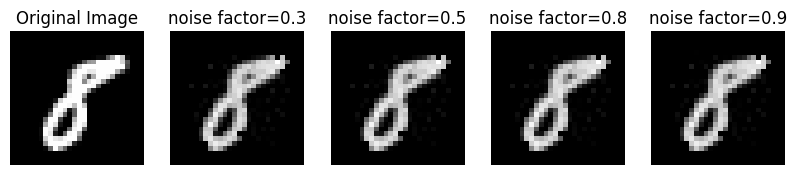

In [55]:
plt.rcParams["figure.figsize"] = (10,6)
i = 7
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")

ax2.imshow(outputs_hid256_01[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('noise factor=0.3')
ax2.axis("off")

ax3.imshow(outputs_hid256_02[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('noise factor=0.5')
ax3.axis("off")

ax4.imshow(outputs_hid256_03[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('noise factor=0.8')
ax4.axis("off")

ax5.imshow(outputs_hid256_04[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title('noise factor=0.9')
ax5.axis("off")

print("Reconstruction Error in VanillaAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_01[i].detach().numpy()/255.)),
                                                                          ((images[i].detach().numpy()/255.)-(outputs_hid256_01[i].detach().numpy()/255.)).T))

print("Reconstruction Error in VanillaAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_02[i].detach().numpy()/255.)),
                                                                          ((images[i].detach().numpy()/255.)-(outputs_hid256_02[i].detach().numpy()/255.)).T))

print("Reconstruction Error in VanillaAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)),
                                                                          ((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)).T))

print("Reconstruction Error in VanillaAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_04[i].detach().numpy()/255.)),
                                                                          ((images[i].detach().numpy()/255.)-(outputs_hid256_04[i].detach().numpy()/255.)).T))


# Manifold learning

In [ ]:
# High-dimensional spaces are sparse: In a 784-dimensional space, valid digit images occupy only a very tiny subset of possible images.
# Random noise disrupts correlations between pixels
# Perception in high dimensions: In high-dimensional spaces, distances between points grow significantlys

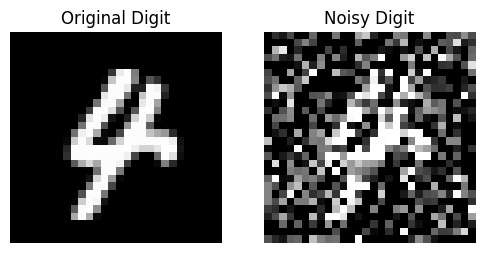

In [56]:
# Select a random digit
random_digit, _ = next(iter(train_loader))

# Original digit
original_digit = random_digit[0].squeeze().numpy()  # Shape (28, 28)

# Add random noise
noise_factor = 0.5
random_noise = np.random.normal(loc=0.0, scale=noise_factor, size=original_digit.shape)
noisy_digit = np.clip(original_digit + random_noise, 0.0, 1.0)  # Keep values in [0, 1]

# Plotting the original and noisy digits
plt.figure(figsize=(6, 3))

# Original digit
plt.subplot(1, 2, 1)
plt.imshow(original_digit, cmap='gray')
plt.title('Original Digit')
plt.axis('off')

# Noisy digit
plt.subplot(1, 2, 2)
plt.imshow(noisy_digit, cmap='gray')
plt.title('Noisy Digit')
plt.axis('off')

plt.show()


In [57]:
class AE_manifold(nn.Module):
    def __init__(self):
        super(AE_manifold, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.Sigmoid()  # Sigmoid to ensure output is in range [0, 1]
        )

    def forward(self, x):
        latent_representation = self.encoder(x)  # Get latent representation
        reconstructed_image = self.decoder(latent_representation)  # Reconstruct the image
        return reconstructed_image, latent_representation  # Return both reconstructed image and latent representation


In [58]:
# Initialize model, loss function, and optimizer
model = AE_manifold()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
training_loss_manifold = []
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.reshape(images.shape[0], -1)  # 2D to 1D vector
        outputs, _ = model(images)  # Reconstructed images and latent representation (we use only the first)
        loss = criterion(outputs, images)  # Reconstruction error
        training_loss_manifold.append(loss.item())

        optimizer.zero_grad()  # Clears the gradients from the previous batch
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

    print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))


Epoch [1/10]: completed, Loss: 0.0727
Epoch [2/10]: completed, Loss: 0.0666
Epoch [3/10]: completed, Loss: 0.0606
Epoch [4/10]: completed, Loss: 0.0537
Epoch [5/10]: completed, Loss: 0.0484
Epoch [6/10]: completed, Loss: 0.0452
Epoch [7/10]: completed, Loss: 0.0417
Epoch [8/10]: completed, Loss: 0.0422
Epoch [9/10]: completed, Loss: 0.0364
Epoch [10/10]: completed, Loss: 0.0387


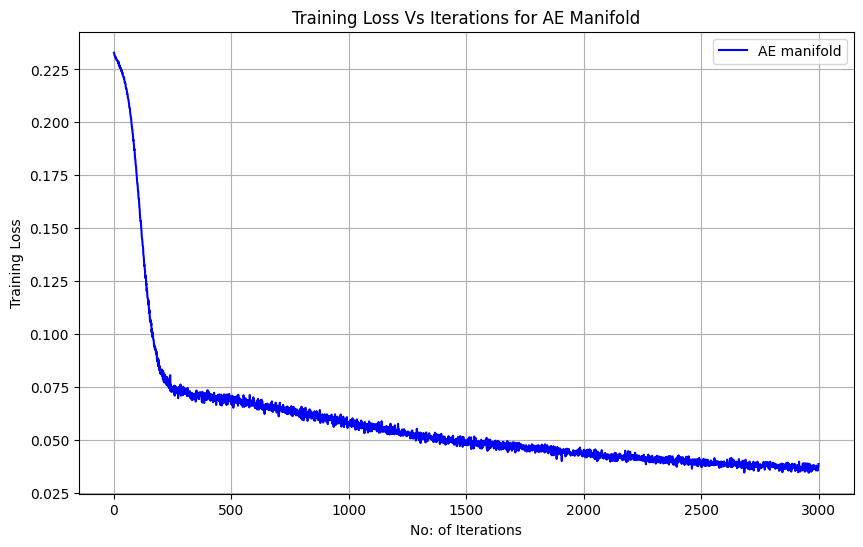

In [59]:
# Plot training loss for the Autoencoder
plt.rcParams["figure.figsize"] = (10, 6)

# the loss per iteration
plt.plot(range(1, len(training_loss_manifold) + 1), training_loss_manifold, label="AE manifold", color='blue')

# Customize plot
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations for AE Manifold")
plt.xlabel("No: of Iterations")
plt.ylabel("Training Loss")
plt.show()


In [60]:
# Testing on the test set
test_image = test_dataset[9705].unsqueeze(0)  # Take a test image and add a batch dimension
test_image = test_image.float() / 255.0  # Normalize

# Pass through encoder to get latent representation
with torch.no_grad():
    reconstructed_image, latent_representation = model(test_image)  # Now it should return both

# Add noise to the latent representation
noise_factor = 0.5
noisy_latent = latent_representation + torch.randn(latent_representation.shape) * noise_factor

# Reconstruct the image from the noisy latent representation
noisy_reconstructed_image = model.decoder(noisy_latent)

# Reshape images for plotting (28x28)
original_image = test_image.view(28, 28).detach().numpy()
noisy_image = noisy_reconstructed_image.view(28, 28).detach().numpy()


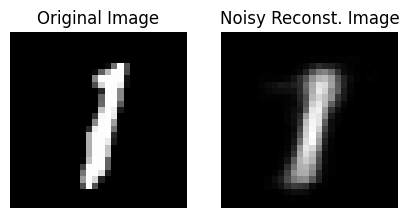

Reconstruction Error for Image 2: 0.00013714117812924087


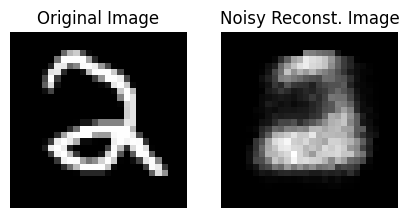

Reconstruction Error for Image 3: 0.0007182587287388742


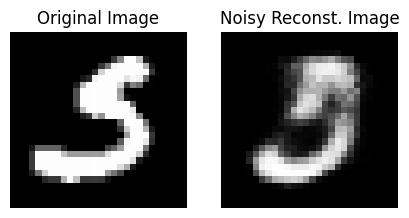

Reconstruction Error for Image 4: 0.0005035301437601447


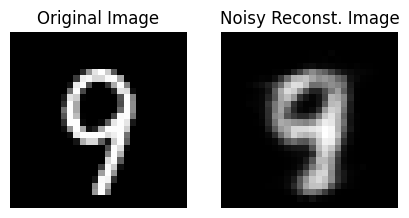

Reconstruction Error for Image 5: 0.0002684948267415166


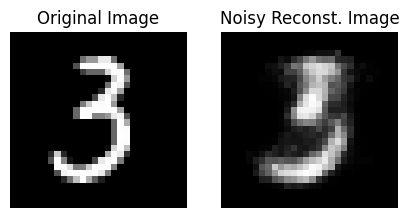

Reconstruction Error for Image 6: 0.00030071643413975835


In [71]:
plt.rcParams["figure.figsize"] = (5, 4)

for i in range(1,6):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Original Image
    ax1.imshow(images[i].detach().numpy().reshape(28, 28), cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis("off")

    # Noisy Reconstructed Image
    ax2.imshow(outputs[i].detach().numpy().reshape(28, 28), cmap='gray')
    ax2.set_title('Noisy Reconst. Image')
    ax2.axis("off")

    plt.show()

    # Calculate and print reconstruction error for this image
    original = images[i].detach().numpy() / 255
    reconstructed = outputs[i].detach().numpy() / 255
    reconstruction_error = np.dot((original - reconstructed), (original - reconstructed).T)

    print(f"Reconstruction Error for Image {i+1}: {reconstruction_error}")


# Convolutional Autoencoders

In [ ]:
class ConvolutionAE_unpooling(nn.Module):   # class definition
  def __init__(self):   # constructor
    super(ConvolutionAE_unpooling,self).__init__()

    # encoder module
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1, padding = 1), # 28x28x1 to 14x14x8
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
    )
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1, padding = 1), # 14x14x8 to 7x7x16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), return_indices = True)
    )
    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1, padding = 1), # 7x7x16 to 3x3x16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2), return_indices = True)
    )

    # decoder module
    self.dec_conv1 = nn.Sequential(nn.Identity()) # 7x7x16 to 7x7x16
    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(16,8, kernel_size = 3, stride = 1, padding = 1), # 14x14x16 to 14x14x8
        nn.ReLU()
    )
    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(8,1, kernel_size = 3, stride = 1, padding = 1), # 28x28x8 to 28x28x1
        nn.ReLU()
    )

    # unpooling operation
    self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))


  def forward(self, x):  # forward pass
    enc_input,indices1  = self.enc_conv1(x.float())  # 28x28x1 to 14x14x8
    enc_input,indices2  = self.enc_conv2(enc_input) #14x14x8 to 7x7x16
    enc_input,indices3  = self.enc_conv3(enc_input) #7x7x16 to 3x3x16

    reconst_img = self.unpool(enc_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
    reconst_img = self.dec_conv1(reconst_img) #7x7x16 to 7x7x16
    reconst_img = self.unpool(reconst_img,indices2) #7x7x16 to 14x14x16
    reconst_img = self.dec_conv2(reconst_img)#14x14x16 to 14x14x8
    reconst_img = self.unpool(reconst_img,indices1)#14x14x8 to 28x28x8
    reconst_img = self.dec_conv3(reconst_img)#28x28x8 to 28x28x1

    return reconst_img, enc_input


In [ ]:
model_conAE1 = ConvolutionAE_unpooling()
criterion_conAE1 = nn.MSELoss()
optimizer_conAE1 = torch.optim.Adam(model_conAE1.parameters(),lr=0.001)

training_loss_conAE1 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs, _ = model_conAE1(images)
    loss = criterion_conAE1(outputs,images)
    training_loss_conAE1.append(loss.item())

    optimizer_conAE1.zero_grad()
    loss.backward()
    optimizer_conAE1.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0146
Epoch [2/10]: completed, Loss: 0.0103
Epoch [3/10]: completed, Loss: 0.0091
Epoch [4/10]: completed, Loss: 0.0079
Epoch [5/10]: completed, Loss: 0.0068
Epoch [6/10]: completed, Loss: 0.0069
Epoch [7/10]: completed, Loss: 0.0059
Epoch [8/10]: completed, Loss: 0.0061
Epoch [9/10]: completed, Loss: 0.0057
Epoch [10/10]: completed, Loss: 0.0055


In [ ]:
class ConvolutionAE_deconv(nn.Module):
  def __init__(self):
    super(ConvolutionAE_deconv, self).__init__()

    # encoder
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )
    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2))
    )


    # decoder
    self.dec_conv1 = nn.Sequential(
        nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
        nn.ReLU()
    )
    self.dec_conv2 = nn.Sequential(
        nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
        nn.ReLU()
    )
    self.dec_conv3 = nn.Sequential(
        nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
        nn.ReLU()
    )

  def forward(self,x):
    enc_input  = self.enc_conv1(x.float())
    enc_input  = self.enc_conv2(enc_input)
    enc_input  = self.enc_conv3(enc_input)

    reconst_img = self.dec_conv1(enc_input)
    reconst_img = self.dec_conv2(reconst_img)
    reconst_img = self.dec_conv3(reconst_img)

    return reconst_img, enc_input


In [ ]:
model_conAE2 = ConvolutionAE_deconv()
criterion_conAE2 = nn.MSELoss()
optimizer_conAE2 = torch.optim.Adam(model_conAE2.parameters(),lr=0.001)

training_loss_conAE2=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs, _ = model_conAE2(images)
    loss = criterion_conAE2(outputs, images)
    training_loss_conAE2.append(loss.item())

    optimizer_conAE2.zero_grad()
    loss.backward()
    optimizer_conAE2.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0245
Epoch [2/10]: completed, Loss: 0.0183
Epoch [3/10]: completed, Loss: 0.0164
Epoch [4/10]: completed, Loss: 0.0151
Epoch [5/10]: completed, Loss: 0.0134
Epoch [6/10]: completed, Loss: 0.0124
Epoch [7/10]: completed, Loss: 0.0129
Epoch [8/10]: completed, Loss: 0.0119
Epoch [9/10]: completed, Loss: 0.0120
Epoch [10/10]: completed, Loss: 0.0117


In [ ]:
class ConvolutionAE_unpool_deconv(nn.Module):
  def __init__(self):
    super(ConvolutionAE_unpool_deconv,self).__init__()

    # encoder
    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(1,8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
    )
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(8,16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
    )
    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(16,16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
    )


    # decoder
    self.dec_conv1 = nn.Sequential(
        nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU()
    )
    self.dec_conv2 = nn.Sequential(
        nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU()
    )
    self.dec_conv3 = nn.Sequential(
        nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU()
    )
    # unpooling
    self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))

  def forward(self,x):
    enc_input,indices1  = self.enc_conv1(x.float())
    enc_input,indices2  = self.enc_conv2(enc_input)
    enc_input,indices3  = self.enc_conv3(enc_input)

    reconst_img  = self.unpool(enc_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
    reconst_img  = self.dec_conv1(reconst_img )
    reconst_img  = self.unpool(reconst_img ,indices2)
    reconst_img  = self.dec_conv2(reconst_img )
    reconst_img  = self.unpool(reconst_img ,indices1)
    reconst_img  = self.dec_conv3(reconst_img )

    return reconst_img, enc_input

In [ ]:
model_conAE3 = ConvolutionAE_unpool_deconv()
criterion_conAE3 = nn.MSELoss()
optimizer_conAE3 = torch.optim.Adam(model_conAE3.parameters(),lr=0.001)

training_loss_conAE3 = []

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs, _ = model_conAE3(images)
    loss = criterion_conAE3(outputs, images)
    training_loss_conAE3.append(loss.item())

    optimizer_conAE3.zero_grad()
    loss.backward()
    optimizer_conAE3.step()

  print("Epoch [{}/{}]: completed, Loss: {:.4f}".format(epoch+1, epochs, loss.item()))

Epoch [1/10]: completed, Loss: 0.0150
Epoch [2/10]: completed, Loss: 0.0105
Epoch [3/10]: completed, Loss: 0.0085
Epoch [4/10]: completed, Loss: 0.0078
Epoch [5/10]: completed, Loss: 0.0065
Epoch [6/10]: completed, Loss: 0.0060
Epoch [7/10]: completed, Loss: 0.0053
Epoch [8/10]: completed, Loss: 0.0047
Epoch [9/10]: completed, Loss: 0.0041
Epoch [10/10]: completed, Loss: 0.0039


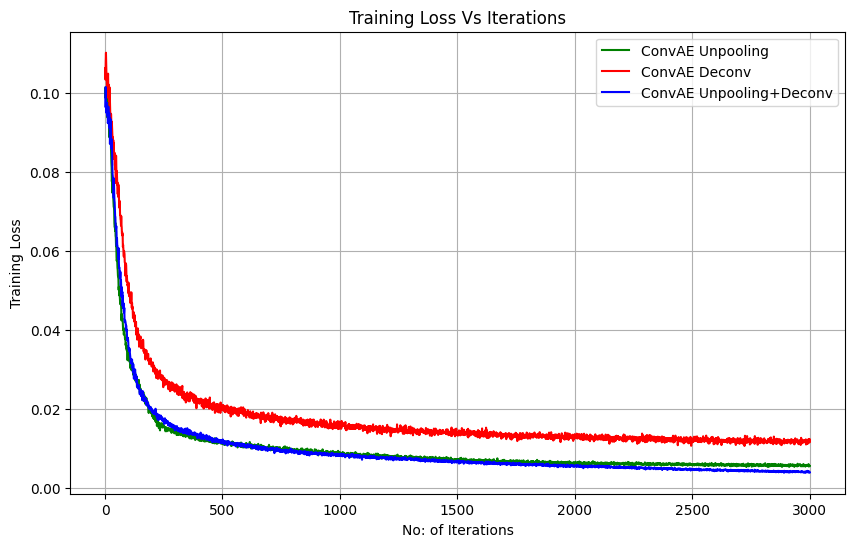

In [ ]:
plt.plot(range(1,len(training_loss_conAE1)+1),training_loss_conAE1 ,label="ConvAE Unpooling",color='green')
plt.plot(range(1,len(training_loss_conAE1)+1),training_loss_conAE2 ,label="ConvAE Deconv",color='red')
plt.plot(range(1,len(training_loss_conAE1 )+1),training_loss_conAE3 ,label="ConvAE Unpooling+Deconv",color='blue')
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("No: of Iterations")
plt.ylabel("Training Loss")
plt.show()

In [ ]:
model_conAE1.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,1,28,28)
    outputs_conAE1, _ = model_conAE1(images.float())


model_conAE2.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,1,28,28)
    outputs_conAE2, _ = model_conAE2(images.float())


activation_conAE3 = []
model_conAE3.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,1,28,28)
    outputs_conAE3, _ = model_conAE3(images.float())

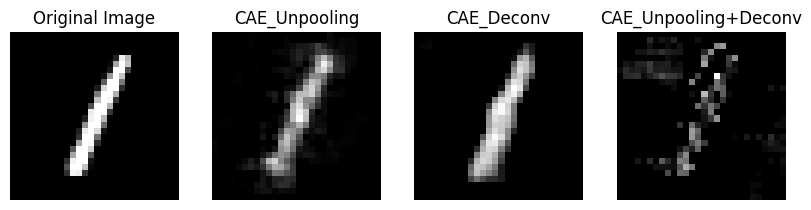

Reconstruction Error in ConvAE Unpooling: 41.09798739985503
Reconstruction Error in ConvAE Deconv: 11.099846611587598
Reconstruction Error in ConvAE Unpooling+Deconv: 157.03552962947595


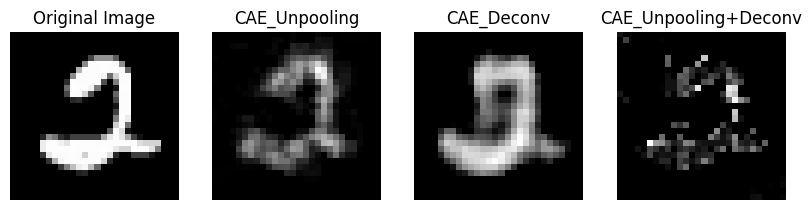

Reconstruction Error in ConvAE Unpooling: 249.00256747616373
Reconstruction Error in ConvAE Deconv: 49.661515593520456
Reconstruction Error in ConvAE Unpooling+Deconv: 906.3791487199521


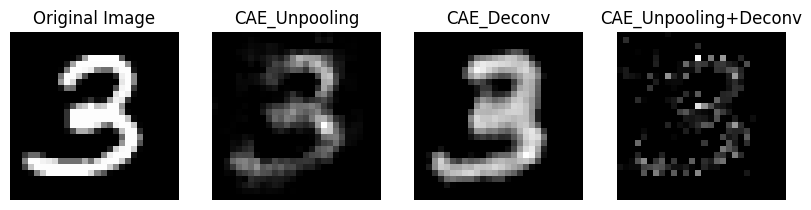

Reconstruction Error in ConvAE Unpooling: 236.94265814368208
Reconstruction Error in ConvAE Deconv: 34.88963381365123
Reconstruction Error in ConvAE Unpooling+Deconv: 708.2955451104583


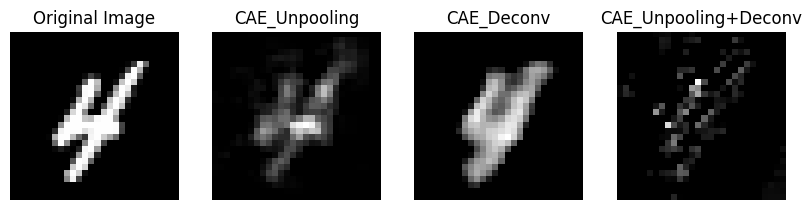

Reconstruction Error in ConvAE Unpooling: 191.92509100020084
Reconstruction Error in ConvAE Deconv: 7.73961747405001
Reconstruction Error in ConvAE Unpooling+Deconv: 538.5825585477866


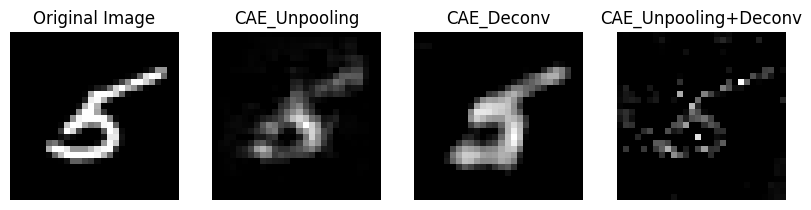

Reconstruction Error in ConvAE Unpooling: 79.80316303619999
Reconstruction Error in ConvAE Deconv: -4.719208042428017
Reconstruction Error in ConvAE Unpooling+Deconv: 256.2937023179323


In [ ]:
plt.rcParams["figure.figsize"] = (10,6)

for i in range(5):
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_conAE1[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('CAE_Unpooling')
  ax2.axis("off")

  ax3.imshow(outputs_conAE2[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('CAE_Deconv')
  ax3.axis("off")

  ax4.imshow(outputs_conAE3[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('CAE_Unpooling+Deconv')
  ax4.axis("off")

  plt.show()

  print("Reconstruction Error in ConvAE Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_conAE1[i].detach().numpy()/255)),
                                                          ((images[i].detach().numpy()/255)-(outputs_conAE1[i].detach().numpy()/255)).T)))

  print("Reconstruction Error in ConvAE Deconv:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_conAE2[i].detach().numpy()/255)),
                                                           ((images[i].detach().numpy()/255)-(outputs_conAE2[i].detach().numpy()/255)).T)))

  print("Reconstruction Error in ConvAE Unpooling+Deconv:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_conAE3[i].detach().numpy()/255)),
                                                                ((images[i].detach().numpy()/255)-(outputs_conAE3[i].detach().numpy()/255)).T)))


In [ ]:
model_conAE1.enc_conv1[0].weight.detach().numpy().squeeze().shape

(8, 3, 3)

In [ ]:
# Function for visualisation of weights
def visualize_tensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

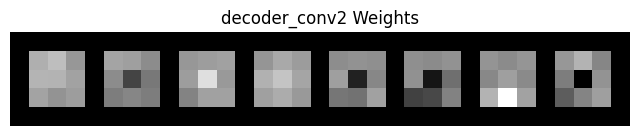

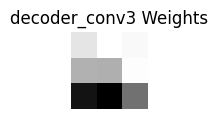

In [ ]:
# Visualising decider weights for convolution Autoencoder with unpooling
filter = model_conAE1.dec_conv2[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_conAE1.dec_conv3[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

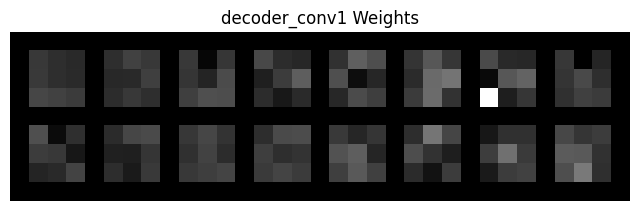

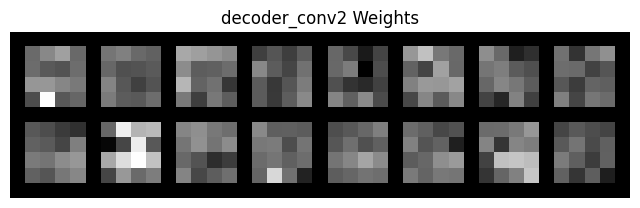

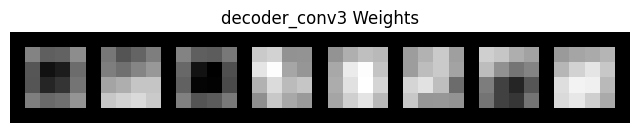

In [ ]:
# Visulalising decoder weights for convolution Autoencoders with deconvolution

filter = model_conAE2.dec_conv1[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_conAE2.dec_conv2[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_conAE2.dec_conv3[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

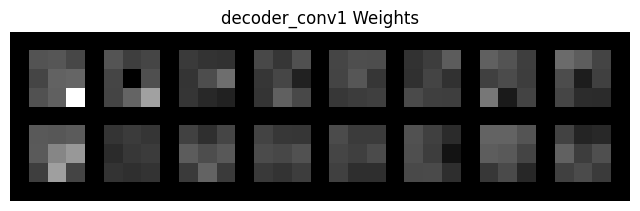

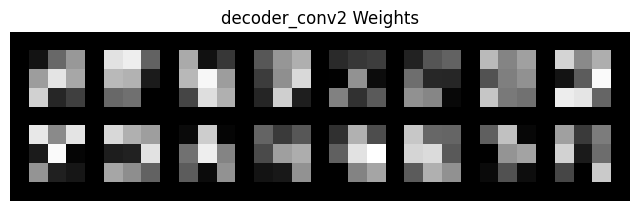

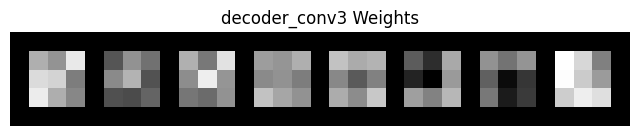

In [ ]:
# Visulalising decoder weights for convolution Autoencoders with unpooling + deconvolution

filter = model_conAE3.dec_conv1[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_conAE3.dec_conv2[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_conAE3.dec_conv3[0].weight.data.clone()
visualize_tensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()
